In [39]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

from shutil import copy2
import glob

import numpy as np
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "trained_models/models_standard"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Eval model and baseline models

In [40]:
%rm -rf trained_models/models_standard/.DS_Store
%rm -rf trained_models/models_standard/piecewise_linear_vector_regression/.DS_Store
%rm -rf trained_models/models_standard/piecewise_linear_regression/.DS_Store
%rm -rf trained_models/models_tiny/.DS_Store
%rm -rf trained_models/models_tiny/piecewise_linear_vector_regression/.DS_Store
%rm -rf trained_models/models_tiny/piecewise_linear_vector_regression_multi_pivot/.DS_Store
%rm -rf trained_models/models_tiny/piecewise_linear_regression/.DS_Store
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,77d790d5-6a46-4380-8d11-f26af1071c2d,piecewise_linear_regression,Transformer,,-1,-1,1,12,8,piecewise_linear_regression
0,19b45183-0a15-4ba1-bc85-5efe7fb680bd,piecewise_linear_vector_regression,Transformer,,-1,-1,10,12,8,piecewise_linear_vector_regression


In [24]:
# ------------------------------------------------------------------
# Pick one global device; on your Mac this will be "cpu".
# ------------------------------------------------------------------
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print("Using device →", DEVICE)

Using device → cpu


In [74]:
task = "piecewise_linear_regression"
# task = "piecewise_linear_vector_regression"
# task = "piecewise_linear_vector_regression_multi_pivot"
# task = "sparse_linear_regression"
# task = "decision_tree"
# task = "relu_2nn_regression"

run_id = "77d790d5-6a46-4380-8d11-f26af1071c2d"

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = True
skip_baselines = True

if recompute_metrics:
    get_run_metrics(run_path, skip_baselines = skip_baselines, DEVICE=DEVICE)  # these are normally precomputed at the end of training

100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]


# Plot pre-computed metrics. The following code block only works some of the time. If it doesn't work, just continue onward.

In [75]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
metrics['standard'].keys()

AttributeError: 'Series' object has no attribute 'task'

# The following code block only works some of the time. If it doesn't work, just continue onward.

In [76]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
if skip_baselines:
    models = ["Transformer"]
basic_plot(metrics["standard"], models=models)
plt.show()

AttributeError: 'Series' object has no attribute 'task'

# The next code block is for model scaling laws. Run the next code block only once per task per model type.

In [77]:
param_counts = []
val_losses = []

# Validation Loss

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Step 100000: 0.267449 ± 0.005213
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Step 200000: 0.268332 ± 0.005622
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Step 300000: 0.258604 ± 0.005089
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math K

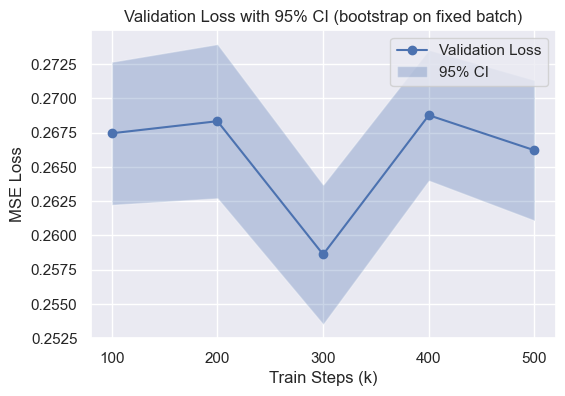

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Final model: 22,365,185 params, MSE = 0.267354


In [78]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from data_generation import get_data_sampler, get_task_sampler
from shutil import copy2
import glob, os, yaml

# ── 0) Paths & settings ──────────────────────────────────────────────
torch.manual_seed(282)
run_path     = os.path.join(run_dir, task, run_id)
orig_state   = os.path.join(run_path, "state.pt")
backup_state = orig_state + ".bak"
DEVICE       = DEVICE

# ── 1) Backup your original state.pt ─────────────────────────────────
if os.path.exists(orig_state):
    copy2(orig_state, backup_state)

# ── 2) Gather checkpoints ─────────────────────────────────────────────
ckpt_paths = sorted(
    glob.glob(os.path.join(run_path, "model_*.pt")),
    key=lambda p: int(os.path.basename(p).split("_")[1].split(".pt")[0])
)

# ── 3) Load config & build samplers ──────────────────────────────────
with open(os.path.join(run_path, "config.yaml")) as f:
    cfg = yaml.safe_load(f)

n_dims     = cfg["model"]["n_dims"]
bsize      = cfg["training"]["batch_size"]
task_name  = cfg["training"]["task"]
task_kwargs= cfg["training"].get("task_kwargs", {})

data_sampler = get_data_sampler(cfg["training"]["data"], n_dims=n_dims)
task_sampler = get_task_sampler(
    task_name, n_dims, bsize,
    n_pivots=cfg["training"].get("n_pivots", None),
    num_tasks=cfg["training"].get("num_tasks", None),
    **task_kwargs
)

# ── 4) Build one fixed validation batch ───────────────────────────────
xs_val = data_sampler.sample_xs(
    cfg["training"]["curriculum"]["points"]["end"],
    bsize,
    cfg["training"]["curriculum"]["dims"]["end"]
).to(DEVICE)
ys_val = task_sampler().evaluate(xs_val).to(DEVICE)

# ── 5) Evaluate each checkpoint & bootstrap CI ───────────────────────
n_boot = 200
records = []

for ckpt in ckpt_paths:
    step = int(os.path.basename(ckpt).split("_")[1].split(".pt")[0])
    model, _ = get_model_from_run(run_path, step=step, DEVICE=DEVICE)
    model.eval()

    # get per‐example MSE on the fixed batch
    with torch.no_grad():
        preds = model(xs_val, ys_val)
    per_example = (preds - ys_val).square().mean(dim=1)  # (bsize,)

    # bootstrap sample means
    boot_means = [
        per_example[torch.randint(0, bsize, (bsize,), device=DEVICE)].mean().item()
        for _ in range(n_boot)
    ]

    mean_mse = float(np.mean(boot_means))
    sem_mse  = float(np.std(boot_means, ddof=1) / np.sqrt(n_boot))

    records.append({
        "step":     step,
        "mse_mean": mean_mse,
        "mse_sem":  sem_mse
    })
    print(f"Step {step}: {mean_mse:.6f} ± {1.96*sem_mse:.6f}")

# ── 6) Restore your original state.pt ─────────────────────────────────
if os.path.exists(backup_state):
    copy2(backup_state, orig_state)

# ── 7) Build DataFrame & CI columns ──────────────────────────────────
df = pd.DataFrame(records).sort_values("step")
df["lower"] = df["mse_mean"] - 1.96 * df["mse_sem"]
df["upper"] = df["mse_mean"] + 1.96 * df["mse_sem"]

# ── 8) Plot mean + 95% CI ───────────────────────────────────────────
plt.figure(figsize=(6,4))
ax = plt.gca()
ax.plot(df["step"], df["mse_mean"], marker="o", label="Validation Loss")
ax.fill_between(df["step"], df["lower"], df["upper"], alpha=0.3, label="95% CI")

ax.xaxis.set_major_locator(ticker.MultipleLocator(100_000))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}"))
plt.title("Validation Loss with 95% CI (bootstrap on fixed batch)")
plt.xlabel("Train Steps (k)")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# ── 9) Final model: count params & compute val‐loss ────────────────
model_final, _ = get_model_from_run(run_path, DEVICE=DEVICE)
model_final.eval()

# count parameters
n_params_final = sum(p.numel() for p in model_final.parameters())

# final MSE on the same fixed batch
with torch.no_grad():
    preds_final = model_final(xs_val, ys_val)
    mse_final   = ((preds_final - ys_val).square().mean().item())

# append to scaling‐law lists
param_counts.append(n_params_final)
val_losses.append(mse_final)

print(f"Final model: {n_params_final:,} params, MSE = {mse_final:.6f}")

In [15]:
print(param_counts)
print(val_losses)

[22367489]
[6.329504013061523]


# Scaling Laws

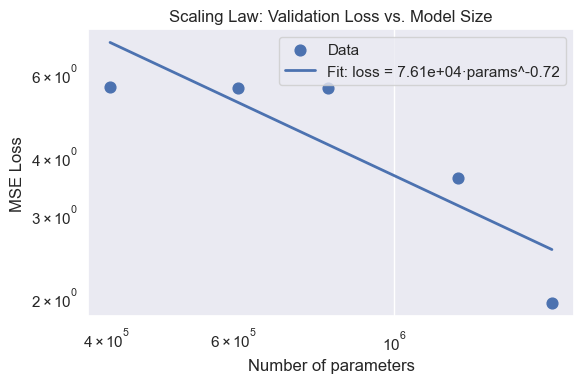

In [128]:
# Convert to numpy arrays
x = np.array(param_counts[:-1])
y = np.array(val_losses[:-1])

# Fit power law: log(y) = b*log(x) + log(a)
logx = np.log(x)
logy = np.log(y)
b, loga = np.polyfit(logx, logy, 1)
a = exp(loga)

# Prepare a smooth curve for plotting
x_fit = np.logspace(np.log10(x.min()), np.log10(x.max()), 200)
y_fit = a * x_fit**b

# Plot
sns.set_theme('notebook', 'darkgrid')
plt.figure(figsize=(6,4))

# scatter of data
plt.scatter(x, y, s=60, label="Data")

# fitted power law line
plt.plot(x_fit, y_fit, lw=2, label=f"Fit: loss = {a:.2e}·params^{b:.2f}")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of parameters")
plt.ylabel("MSE Loss")
plt.title("Scaling Law: Validation Loss vs. Model Size")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Train/Val Loss Curve

In [ ]:
import wandb
import matplotlib.pyplot as plt

# 1) Initialize the API
api = wandb.Api()

# 2) Load your run by its full path: "<entity>/<project>/<run_id>"
#    e.g. "myusername/myproject/abcd1234"
run_path = "qianyu2025-university-of-california-berkeley/in-context-training/vald3twu" # standard piecewise scalar
# run_path = "qianyu2025-university-of-california-berkeley/in-context-training/9mcne8c0" # tiny piecewise scalar
run = api.run(f"{run_path}")  # e.g. "me/myproj/abc123"

In [ ]:
# 3) Download the history for just the two loss keys
hist = run.history(keys=["overall_loss"])

# 4) Convert to Python lists
train_losses = hist["overall_loss"].tolist()


# 5) Plot
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Train Steps (k)")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

## Plot OOD metric

In [22]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [20]:
from data_generation import get_data_sampler, get_task_sampler

In [21]:
model, conf = get_model_from_run(run_path,DEVICE=DEVICE)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [22]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [23]:
with torch.no_grad():
    pred = model(xs, ys)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


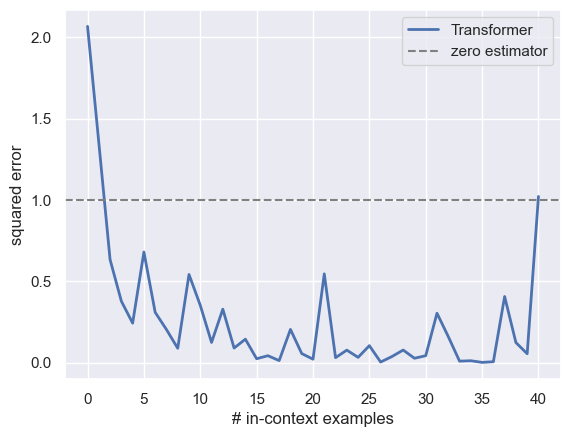

In [24]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "piecewise_linear_regression": 1,
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [11]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

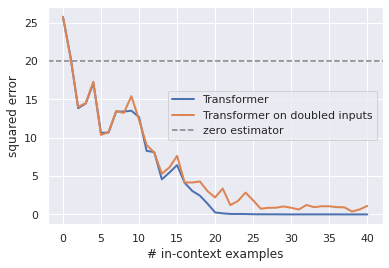

In [12]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.